In [1]:
import numpy as np
import pandas as pd
from numba import jit
import time
import scipy as sp
from scipy import interpolate, integrate
import matplotlib.pyplot as plt
from itertools import product
from walker import WalkerRandomSampling

plt.style.use('fast')
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'errorbar.capsize': 2})
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Serif']

**This code is owned and was written by Mayura Balakrishnan (bmayura@umich.edu). Please contact me with any questions, and feel free to reach out if you want a deeper explanation or some help.**

As is about to be clear, I am not a coder. 

# Setting Things Up

The following cell loads everything in. The HMXB, BH, and SNR distribution catalogs only had objects from the galaxy. The LMXBCAT catalog, however, included low mass X-ray binaries (LMXBs) from the Magellanic clouds, so 2A 0521-720 (also known as LMC X-2) was deleted from the catalog. In addition, we eliminated Cir X-1/3A 1516-569, W63/W63 X-1, and W50/SS433 from the distributions because those overlaps are not coincidental.

In [2]:
#just loading things in

#from the SNR catalog
SNR_cat = pd.read_csv("SNR_catalog.csv", skiprows=3, header=None)
SNR_cat.columns = ["l", "b", "RA", "Dec", "size", "type", "1-GHz flux", "spectral index", "other names", 'height', 'width', '1-GHz_forcode', 'type_for_code']

#dropping SNRs that are not coincidentally associated with XRBs
SNR_cat = SNR_cat.drop(223, axis=0) #Cir X-1
SNR_cat = SNR_cat.drop(132, axis=0) #W 63
SNR_cat = SNR_cat.drop(95, axis=0) #W 50
SNR_cat = SNR_cat.drop(274, axis=0) #our remnant!

SNR_cat = SNR_cat.drop(239, axis=0) #RCW 103
SNR_cat = SNR_cat.drop(156, axis=0) #CI Cam

SNR_cat.index = range(len(SNR_cat))

#loading HMXB catalog
HMXB_cat = pd.read_csv("HMXB_catalog.csv", header=None)
HMXB_cat.columns = ["Source name", "X-ray type","RA", "Dec", "l", "b", "Optical counterpart type", "Other name", ""]
HMXB_cat = HMXB_cat.drop(104, axis=0) #W 63
HMXB_cat = HMXB_cat.drop(97, axis=0) #W 50

HMXB_cat = HMXB_cat.drop(10, axis=0) #CI Cam

HMXB_cat.index = range(len(HMXB_cat))

#loading LMXB catalog
LMXB_cat = pd.read_csv("LMXB_catalog.csv", header=None)
LMXB_cat.columns = ["Source name", "X-ray type","RA", "Dec", "l", "b", "Other name"]
LMXB_cat = LMXB_cat.drop(25, axis=0) #Cir X-1
LMXB_cat = LMXB_cat.drop(34, axis=0) #RCW 103
LMXB_cat.index = range(len(LMXB_cat))

#SNR ls and bs, for height and width, converting it to degrees
SNR_ls, SNR_bs = SNR_cat["l"], SNR_cat["b"]
SNR_heights, SNR_width = SNR_cat['height']*0.0166667, SNR_cat['width']*0.0166667

#creating SNR 'boxes'
SNR_widths = []
for i in range(len(SNR_heights)):
    if (pd.isnull(SNR_width[i]) == True):
        SNR_widths.append(SNR_heights[i])
    else:
        SNR_widths.append(SNR_width[i])
SNR_widths = np.array(SNR_widths)



#HMXB and LMXB ls and bs
HMXB_ls, HMXB_bs = HMXB_cat["l"], HMXB_cat["b"]
LMXB_ls, LMXB_bs = LMXB_cat["l"], LMXB_cat["b"]


#just for formatting dumb SNR and LMXB distance arrays
def fix(pandas_arr):
    new = []
    for i in range(len(pandas_arr)):
        new.append(pandas_arr.to_numpy()[i][0])
    return new

#distances to all populations
HMXB_dists = pd.read_csv("HMXB_dist_table.csv")["Distance (kpc)"] #kpc
SNR_dists = fix(pd.read_csv("SNR_dist_table.csv", usecols=[4])) #kpc
LMXB_dists = fix(pd.read_csv("LMXB_dists.csv", skiprows=2, usecols=[9]))

#deleting the nan
del LMXB_dists[7]

#loading BH catalog
just_BHs = pd.read_csv("just_BHs.csv")
BH_ls = just_BHs['ℓ'].dropna().values
BH_bs = just_BHs.iloc[:,5].dropna().values
BH_dists = just_BHs['d_code'].dropna().values

In the next cell, I try to show code I used to figure out 'num_samps_x' for all the different parameter distributions I'm dealing with: LMXB galactic latitude, longitude, distance, HMXB galactic latitude, longitude, distance, BH latitude, longitude, distance, and SNR galactic latitude, longitude, height, width, and distance.

In [3]:
'''
used this function to get the number of samples needed for each parameter (LMXB l, LMXB b, etc)
that would return, on average, the number of that population in the milky way
'''

def num_samples_needed(low_range, up_range, distribution, total_MW_num, stepsize, sim_run_num):
    #array to step through
    input_nums = np.arange(low_range,up_range,stepsize)
    peak_of_dist = []
    #stepping through the array
    for input_num in input_nums:
        sim_runs = 0
        num_resulting_samples = []
        while sim_runs < sim_run_num:
            num_resulting_samples.append(len(rejection_sampling(simple_smoothing(distribution), input_num)))
            sim_runs += 1
        #collecting the peak of the distribution each time
        peak_of_dist.append(np.median(num_resulting_samples))
    peak_of_dist = np.array(peak_of_dist) 
    return input_nums[np.argmin(np.abs(peak_of_dist - total_MW_num))]

# then used code that was like this, but I tweaked the bounds and decreased the increments and stuff to get the 
# right numbers, for each population,

# print(num_samples_needed(7000, 7100, SNR_bs, len(SNR_bs), 1, 50))
# print(num_samples_needed(1504, 1508, SNR_ls, len(SNR_ls), 1, 50))
# print(num_samples_needed(3425, 3435, SNR_heights, len(SNR_heights), 2, 50))
# print(num_samples_needed(3425, 3435, SNR_widths, len(SNR_sizes), 2, 50))
# print(num_samples_needed(3528, 3535, SNR_dists, len(SNR_ls), 1, 50))
# print(num_samples_needed(5265, 5270, LMXB_ls, len(LMXB_ls), 1, 50))
# print(num_samples_needed(3640,3645, LMXB_bs, len(LMXB_bs), 1, 50))
# print(num_samples_needed(845,850, HMXB_ls, len(HMXB_ls), 1, 50))
# print(num_samples_needed(1740,1760, HMXB_bs, len(HMXB_bs), 1, 50))
# print(num_samples_needed(705,715, BH_bs, len(BH_bs), 1, 50))
# print(num_samples_needed(1465,1475, BH_ls, len(BH_ls), 2, 50))
# print(num_samples_needed(580,620, BH_dists, len(BH_ls), 10, 20))
# print(num_samples_needed(1390,1430, LMXB_dists, len(LMXB_ls), 10, 20))
# print(num_samples_needed(800,1000, HMXB_dists, len(HMXB_ls), 50, 20))
# print(num_samples_needed(586,596, BH_dists, len(BH_ls), 1, 50))
# print(num_samples_needed(1390,1400, LMXB_dists, len(LMXB_ls), 1, 50))
# print(num_samples_needed(845,855, HMXB_dists, len(HMXB_ls),1, 50))

# which resulted in the following:
# which is accurate to the ~2 ish, it's hard to be consistent when it comes to statistical variation

'''
This is important. XRB and SNR factor add factors to the number of objects simulated each time, in each galaxy.
'''
XRB_factor = 1
SNR_factor = 1

'''
now the actual number of samples, calculated using trial and error and the above num_samples_needed function
'''

numsamps_SNR_ls, numsamps_SNR_bs = 1506*SNR_factor, 7005
numsamps_SNR_heights, numsamps_SNR_widths, numsamps_SNR_dists = 4329, 3429, 3531
numsamps_LMXB_ls, numsamps_LMXB_bs = 5267*XRB_factor, 3642*XRB_factor
numsamps_HMXB_ls, numsamps_HMXB_bs = 848*XRB_factor, 1756*XRB_factor
numsamps_BH_ls, numsamps_BH_bs = 1473*XRB_factor,712*XRB_factor
numsamps_BH_dists, numsamps_LMXB_dists, numsamps_HMXB_dists = 594*XRB_factor, 1395*XRB_factor, 849*XRB_factor

Is there a way to do that more efficiently? Absolutely. I just needed this to work at some point though.

Now we define some functions to smooth a jagged distribution (simple_smoothing) and to run rejection sampling. The rejection sampling code just makes a grid of values and all values under a probability distribution get 'accepted'. A histogram of the sampled values then is very similar to the original histogram.

In [4]:
# input: the initial distribution for smoothing
# output: x values and the function for a smoothed distribution
# this function takes a histogram and uses the bin centers and interpolating to create a smoothed distribution function
def simple_smoothing(rough_dist):
    """
    Returns continuous x-values and a function object that represents the smoothed distribution.
    Parameters
    ----------
    rough_dist : array
        1D original array
        
    Returns
    -------
    output : 2 arrays
        more continuous x-values and function object where an input array of x-values will return the smoothed distribution
    """
    n,x,_ = plt.hist(rough_dist, bins = 125)
    plt.clf()
    bin_centers = 0.5*(x[1:]+x[:-1])
    p = interpolate.interp1d(bin_centers, n, fill_value='extrapolate')
    newx = np.linspace(np.min(rough_dist), np.max(rough_dist), 100)
    return newx, p(newx)


# input: the xs and ys of distribution to sample (the x and y values of the histogram of a distribution)
# output: simulated distribution
# this code takes an initial grid, 'overlays' the probability distribution, and returns the variables that fall within the distribution. Monte carlo rejection sampling
def rejection_sampling(xy, size):
    """
    Returns a new array of values that will have a very similar probability function to the original set of values.

    Parameters
    ----------
    xy : 2-D array of x- and y- values (from simple_smoothing function)
    size : length of grid of values to input
        
    Returns
    -------
    output : array
        new set of values
    """
    x, y = xy[0], xy[1]
    xs = np.random.uniform(np.min(x), np.max(x), size)
    ys = np.random.uniform(np.min(y), np.max(y), size)
    p = interpolate.interp1d(x, y)
    variables = xs[ys <= p(xs)]
    return variables

#making smoothed distributions for everything
smoothed_SNR_ls, smoothed_SNR_bs = simple_smoothing(SNR_ls), simple_smoothing(SNR_bs)
smoothed_SNR_heights, smoothed_SNR_widths = simple_smoothing(SNR_heights), simple_smoothing(SNR_widths)
smoothed_LMXB_ls, smoothed_LMXB_bs = simple_smoothing(LMXB_ls), simple_smoothing(LMXB_bs)
smoothed_HMXB_ls, smoothed_HMXB_bs = simple_smoothing(HMXB_ls), simple_smoothing(HMXB_bs)
smoothed_BH_bs, smoothed_BH_ls = simple_smoothing(BH_bs),simple_smoothing(BH_ls)

smoothed_SNR_dists = simple_smoothing(SNR_dists)
smoothed_HMXB_dists = simple_smoothing(HMXB_dists)
smoothed_LMXB_dists = simple_smoothing(np.sort(LMXB_dists))
smoothed_BH_dists = simple_smoothing(BH_dists)


<Figure size 720x720 with 0 Axes>

In [5]:
'''
The next three functions just trim arrays. They take in x number of arrays and return versions
of all the arrays that are cut to the length of the shortest input array. This is because the rejection sampling
returns a different number of samples each time.
'''
 
def trim2(arr1, arr2):
    m = min(len(arr1), len(arr2))
    a,b= arr1[:m], arr2[:m]
    return a,b

def trim3(arr1, arr2, arr3): 
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), m)
    a,b,c = arr1[:n], arr2[:n], arr3[:n]
    return a,b,c

def trim4(arr1, arr2, arr3, arr4):
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), len(arr4))
    mn = min(m, n)
    a,b,c,d = arr1[:mn], arr2[:mn], arr3[:mn], arr4[:mn]
    return a,b,c,d

def trim5(arr1, arr2, arr3, arr4, arr5):
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), len(arr4))
    o = len(arr5)
    mn = min(m, n)
    mno = min(mn, o)
    a,b,c,d,e = arr1[:mno], arr2[:mno], arr3[:mno], arr4[:mno], arr5[:mno]
    return a,b,c,d,e

In [6]:
'''
The following chunk of code creates the distribution from which to sample the SNR l values and sizes.
We found that the SNR l values and sizes are in no way independent, as the large remnants tend to be toward the 
galactic anti-center. Using the Walker alias method allows us to sample from the joint supernova remnant galactic
longitude and size distribution. Here we create the 'wrand' variable and that is what we use to simulate new
SNR populations.
'''
# for SNR heights
num=100 #this is an arbitrary number really
h = np.histogram2d(SNR_heights, SNR_ls, bins=num)[0] #this creates the joint distribution
y = np.linspace(np.min(SNR_ls),np.max(SNR_ls), num)
x = np.linspace(np.min(SNR_heights),np.max(SNR_heights),num)
values = h.flatten()
keys = list(product(x, y))
values = h.flatten()
wrand_height_l = WalkerRandomSampling(weights=values, keys=keys) #this creates the variable we will use later

# for SNR widths
y = np.linspace(np.min(SNR_widths),np.max(SNR_widths), num)
x = np.linspace(np.min(SNR_heights),np.max(SNR_heights),num)
values = h.flatten()
keys = list(product(x, y))
values = h.flatten()
wrand_width_height = WalkerRandomSampling(weights=values, keys=keys) #this creates the variable we will use later

In [7]:
'''
Important parameters that will get set: d (d=2 means an overlap is XRB/BH falls anywhere within SNR, 
d=4 means an overlap if XRB/BH is within central half)
'''

def count_overlaps(SNRs, HMXBs, LMXBs, BHs):
    """
    Returns number of overlaps, given populations of SNRs, HMXBs, LMXBs, and BHs. Does not take into account distance

    Parameters
    ----------
    parameter arrays for SNRs (SNR_l, b, size), HMXBs (l, b), LMXBs (l,b), and BHs (l,b)
    
        
    Returns
    -------
    output : number of HMXBs, LMXBs, and BHs that overlap with SNRs, and XRB overlaps/number of XRBs 
        and BH overlaps/number of BHs
    """
    #initialising 
    HMXB_overlaps, LMXB_overlaps, BH_overlaps = 0,0,0
    #unpacking
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = SNRs 
    sim_HMXB_ls, sim_HMXB_bs = HMXBs
    sim_LMXB_ls, sim_LMXB_bs = LMXBs
    sim_BH_ls, sim_BH_bs = BHs
    # for each SNR...
    for i in range(len(sim_SNR_ls)):
        # for each HMXB...
        for j in range(len(sim_HMXB_ls)):
            # if the galactic latitude and longitude fit within the SNR, then there's an overlap
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_HMXB_ls[j] < sim_SNR_ls[i]+sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_HMXB_bs[j] < sim_SNR_bs[i]+sim_SNR_heights[i]/d:
                    HMXB_overlaps += 1
                    
        # for each LMXB...
        for k in range(len(sim_LMXB_ls)):
            # if the galactic latitude and longitude fit within the SNR, then there's an overlap
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_LMXB_ls[k] < sim_SNR_ls[i]+sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_LMXB_bs[k] < sim_SNR_bs[i]+sim_SNR_heights[i]/d:
                    LMXB_overlaps += 1
        #for each BH...
        for l in range(len(sim_BH_ls)):
            # if the galactic latitude and longitude fit within the SNR, then there's an overlap
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_BH_ls[l] < sim_SNR_ls[i] + sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_BH_bs[l] < sim_SNR_bs[i] + sim_SNR_heights[i]/d:
                    BH_overlaps += 1
                    
    return (HMXB_overlaps+LMXB_overlaps)/len(SNR_ls),(BH_overlaps)/len(SNR_ls) 
 
def simulate_populations():
    """
    Returns simulated populations of SNRs, HMXBs, LMXBs, and BHs.
    Parameters
    ----------
    input: nothing
    
        
    Returns
    -------
    output : number of HMXBs, LMXBs, and BHs that overlap with SNRs, and XRB overlaps/number of XRBs 
        and BH overlaps/number of BHs
    """
    sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
    sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
    sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
    sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    
    '''
    this next chunk of code accounts for the fact that the sizes of SNRs is connected to galactic longitude
    bigger remnants are more easily seen towards galactic anti-center.
    Using the galactic wrand variable which contains information for the galactic SNR_ls and SNR_sizes,
    '''
    samples_hl = wrand_height_l.random(len(sim_SNR_bs))
    sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]
    
    samples_hw = wrand_width_height.random(len(sim_SNR_heights))
    sim_SNR_widths = samples_hw[:,0]
    
    sim_LMXB_ls = rejection_sampling(smoothed_LMXB_ls, numsamps_LMXB_ls)
    sim_LMXB_bs = rejection_sampling(smoothed_LMXB_bs, numsamps_LMXB_bs)

    sim_HMXB_ls = rejection_sampling(smoothed_HMXB_ls, numsamps_HMXB_ls)
    sim_HMXB_bs = rejection_sampling(smoothed_HMXB_bs, numsamps_HMXB_bs)
    
    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)

    #trimming arrays so arrays within a population are all the same length
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    sim_LMXB_ls, sim_LMXB_bs = trim2(sim_LMXB_ls, sim_LMXB_bs)
    sim_HMXB_ls, sim_HMXB_bs = trim2(sim_HMXB_ls, sim_HMXB_bs)
    sim_BH_ls, sim_BH_bs = trim2(sim_BH_ls, sim_BH_bs)
    
    SNRs = sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths
    HMXBs = sim_HMXB_ls, sim_HMXB_bs 
    LMXBs = sim_LMXB_ls, sim_LMXB_bs 
    BHs = sim_BH_ls, sim_BH_bs
    print("Simulated %.0i SNRs, %.0i HMXBs, %.0i LMXBs, and %.0i BHs." % (len(sim_SNR_ls), len(sim_HMXB_ls), len(sim_LMXB_ls), len(sim_BH_ls)) )
    return SNRs, HMXBs, LMXBs, BHs


# this function counts overlaps and takes into account a distance constraint
def count_overlaps_withdist(SNRs, HMXBs, LMXBs, BHs):
    '''
    Same as above count_overlaps function but takes into account distance.
    '''
    HMXB_overlaps, LMXB_overlaps, BH_overlaps = 0,0,0
    
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = SNRs 
    sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists = HMXBs
    sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists = LMXBs
    sim_BH_ls, sim_BH_bs, sim_BH_dists = BHs
    

    for i in range(len(sim_SNR_ls)):
        dL_low, dL_up = get_dLs_for_SNR(sim_SNR_ls[i], sim_SNR_dists[i])
        for j in range(len(sim_HMXB_ls)):
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_HMXB_ls[j] < sim_SNR_ls[i]+sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_HMXB_bs[j] < sim_SNR_bs[i]+sim_SNR_heights[i]/d:
                    if dL_low < sim_HMXB_dists[j] < dL_up:
                        HMXB_overlaps += 1
        for k in range(len(sim_LMXB_ls)):
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_LMXB_ls[k] < sim_SNR_ls[i]+sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_LMXB_bs[k] < sim_SNR_bs[i]+sim_SNR_heights[i]/d:
                    if dL_low < sim_LMXB_dists[k] < dL_up:
                        LMXB_overlaps += 1
        #how many BHs overlap?
        for l in range(len(sim_BH_ls)):
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_BH_ls[l] < sim_SNR_ls[i] + sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_BH_bs[l] < sim_SNR_bs[i] + sim_SNR_heights[i]/d:
                    if dL_low < sim_BH_dists[l] < dL_up:
                        BH_overlaps += 1
                        
    
    return (HMXB_overlaps+LMXB_overlaps)/len(SNR_ls),(BH_overlaps)/len(SNR_ls) 

def simulate_populations_withdist():
    '''
    Same as above simulate_populations function generates distance arrays for everything as well.
    '''
    sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
    sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
    sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
    sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)
    
    sim_SNR_dists = rejection_sampling(smoothed_SNR_dists, numsamps_SNR_dists)
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    
    
    samples_hl = wrand_height_l.random(len(sim_SNR_bs))
    sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]
    
    samples_hw = wrand_width_height.random(len(sim_SNR_heights))
    sim_SNR_widths = samples_hw[:,0]
    
    sim_LMXB_ls = rejection_sampling(smoothed_LMXB_ls, numsamps_LMXB_ls)
    sim_LMXB_bs = rejection_sampling(smoothed_LMXB_bs, numsamps_LMXB_bs)

    sim_HMXB_ls = rejection_sampling(smoothed_HMXB_ls, numsamps_HMXB_ls)
    sim_HMXB_bs = rejection_sampling(smoothed_HMXB_bs, numsamps_HMXB_bs)
    
    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)
    
    sim_LMXB_dists = rejection_sampling(smoothed_LMXB_dists, numsamps_LMXB_dists)
    sim_HMXB_dists = rejection_sampling(smoothed_HMXB_dists, numsamps_HMXB_dists)
    
    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)
    sim_BH_dists = rejection_sampling(smoothed_BH_dists, numsamps_BH_dists)

    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = trim5(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists)
    sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists = trim3(sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists)
    sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists = trim3(sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists)
    sim_BH_ls, sim_BH_bs, sim_BH_dists = trim3(sim_BH_ls, sim_BH_bs,sim_BH_dists)
    
    SNRs = sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists
    HMXBs = sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists
    LMXBs = sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists
    BHs = sim_BH_ls, sim_BH_bs,sim_BH_dists
    print("Simulated %.0i SNRs, %.0i HMXBs, %.0i LMXBs, and %.0i BHs." % (len(sim_SNR_ls), len(sim_HMXB_ls), len(sim_LMXB_ls), len(sim_BH_ls)) )
    return SNRs, HMXBs, LMXBs, BHs

The following cell of code is where the distance constraint comes in. In this simulation, an overlap occurs if the distance to the XRB/BH would return a column density $\textit{within 25 %}$ of the column density measured at the SNR's distance.

In [8]:
'''
The following code loads in the n_H values for different radii in the galaxy.
Note this technique only works for sources near the Galactic Plane.
'''
# loading in nH data. This .csv file is a combination of 2 n_H distributions:
# Kalberla & Kerp 2009 + Marasco et al. 2017
nH_data = pd.read_csv("fullrange_nH.csv", header=None, names=['radius(kpc)', 'density'])
nH_r, nH_density = nH_data['radius(kpc)'], nH_data['density']
nH_density = [x for _, x in sorted(zip(nH_r, nH_density))]
nH_r = np.sort(nH_r)

#making smoothed using interpolate version
new_r = np.linspace(np.min(nH_r), np.max(nH_r), 10000)
new_r_cm = new_r*3.086e21 #pc to cm
k = interpolate.interp1d(nH_r, nH_density)
new_density = k(new_r)

factor = 0.25 # THIS IS THE ERROR ON N_H MEASURED FROM THE CHANDRA SPECTRUM OF G351.9-0.9

def find_nearest(array, value):
    '''
    Finds value in a given array closest to input value and returns the index.
    Parameters
    ----------
    input: array, float
        array of interest and float value of interest
    
        
    Returns
    -------
    output : int
        the index of the value closest to input value in that array
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_dLs(distsfromus, nH_in_this_los, given_dist):
    '''
    Gets string of lower and upper distance bounds that correspond to a given line of sight / galactic longitude.
    ----------
    input: 2 arrays and a float
        distance array to iterate over, n_H distribution along this line of sight, distance of interest
        distsfromus should be an array from 0 to 22 with some step, and nH_in_this_los is the nH distribution in
        the line of sight of interest. The given_dist is the distance at which to evaluate the upper and lower bounds
    
        
    Returns
    -------
    output : 2 floats
        Lower distance and upper distance bounds that would return +- 25% of the column density to the input distance.
    '''
    nearest_dist = find_nearest(distsfromus, given_dist)
    
    #initial NH, to the distance of interest
    NH_initial = integrate.trapz(y=nH_in_this_los[1:nearest_dist],x=distsfromus[1:nearest_dist]*3.086e21)

    #lower and upper NH bounds
    low_NH = NH_initial - factor*NH_initial
    high_NH = NH_initial + factor*NH_initial
    
    # starting from the input distance, integrate to lower and lower distances until we reach NH - 0.25*NH
    dist_of_interest = given_dist
    NH = NH_initial
    # this is the lower limit that this code can really handle, a higher resolution results in lower bounds, but
    # this really doesn't affect the results and increasing the resolution results in an exponential increase
    # in running the full code later
    if low_NH > 7e20:
        #this part just says, keep lowering the distance until the integrated column is NH - 0.25*NH
        while NH/low_NH > 0.999:
            nearest_dist = find_nearest(distsfromus, dist_of_interest)
            NH = integrate.trapz(y=nH_in_this_los[1:nearest_dist],x=distsfromus[1:nearest_dist]*3.086e21)

            dist_of_interest -= 0.01
        lower_dist = dist_of_interest
    # if the lower NH bound is lower than 7e20 /cm2, then we can say the SNR is very close and assume a homogenous
    # nH distribution, so dL = 0.25*L
    else:
        lower_dist = given_dist - factor*given_dist

    # now we go the other way, to get the upper bound. Starting at the input distance, integrate to higher and higher
    # distances until we reach NH + 0.25*NH
    dist_of_interest = given_dist
    while NH/high_NH < 0.999:
        nearest_dist = find_nearest(distsfromus, dist_of_interest)
        NH = integrate.trapz(y=nH_in_this_los[1:nearest_dist],x=distsfromus[1:nearest_dist]*3.086e21)

        dist_of_interest += 0.01
        
        #if the error is going outside the range of the furthest SNRs, stop looping
        if dist_of_interest > 22:
            NH = high_NH*1.01
    upper_dist = dist_of_interest
    return lower_dist, upper_dist

def get_dLs_for_SNR(l, SNR_dist):
    '''
    Returns upper and lower distance bounds that correspond to a range where the column density is 
    consistent to the SNR's column density to within 25%, for a given distance and l value.
    ----------
    input: 2 floats
        galactic longitude of the SNR, and its distance
    
        
    Returns
    -------
    output : 2 floats
        Lower distance and upper distance bounds that would return +- 25% of the column density to the 
        input distance and galactic longitude.
    '''
    distsfromus = np.linspace(0,22,1000)
    R0=8
    nH_in_this_los = []
    #calculating nH distribution in this line of sight
    for dist in distsfromus:
        R = np.sqrt( (R0)**2 + (dist**2) - 2*R0*dist*(np.cos(np.deg2rad(l))) )
        nearest_radius = find_nearest(new_r, R)
        nH_in_this_los.append(new_density[nearest_radius])
    #using the above function to get the upper and lower distance bounds
    return get_dLs(distsfromus, nH_in_this_los, SNR_dist)

#testing the code, seeing how long it takes
tt = time.time()
print(get_dLs_for_SNR(351.9, 8.6))
print("time taken for dL stuff was ", time.time()-tt)

(5.960000000000056, 11.279999999999943)
time taken for dL stuff was  0.045128822326660156


# Testing

In the following blocks, I simulate a galaxy and plot the simulated parameters (purple) and the original parameters (orange) to show that this procedure accurately reproduces Milky-Way like distributions for LMXB galactic latitude, longitude, distance, HMXB galactic latitude, longitude, distance, BH latitude, longitude, distance, and SNR galactic latitude, longitude, height, width, and distance.

In [9]:
from walker import WalkerRandomSampling
from itertools import *

#this and the next cell is just to show how the simulating works
sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)

sim_SNR_dists = rejection_sampling(smoothed_SNR_dists, numsamps_SNR_dists)
sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)


samples_hl = wrand_height_l.random(len(sim_SNR_bs))
sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]

samples_hw = wrand_width_height.random(len(sim_SNR_heights))
sim_SNR_widths = samples_hw[:,0]

sim_LMXB_ls = rejection_sampling(smoothed_LMXB_ls, numsamps_LMXB_ls)
sim_LMXB_bs = rejection_sampling(smoothed_LMXB_bs, numsamps_LMXB_bs)

sim_HMXB_ls = rejection_sampling(smoothed_HMXB_ls, numsamps_HMXB_ls)
sim_HMXB_bs = rejection_sampling(smoothed_HMXB_bs, numsamps_HMXB_bs)

sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)

sim_LMXB_dists = rejection_sampling(smoothed_LMXB_dists, numsamps_LMXB_dists)
sim_HMXB_dists = rejection_sampling(smoothed_HMXB_dists, numsamps_HMXB_dists)

sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)
sim_BH_dists = rejection_sampling(smoothed_BH_dists, numsamps_BH_dists)

sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = trim5(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists)
sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists = trim3(sim_LMXB_ls, sim_LMXB_bs,sim_LMXB_dists)
sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists = trim3(sim_HMXB_ls, sim_HMXB_bs,sim_HMXB_dists)
sim_BH_ls, sim_BH_bs, sim_BH_dists = trim3(sim_BH_ls, sim_BH_bs,sim_BH_dists)


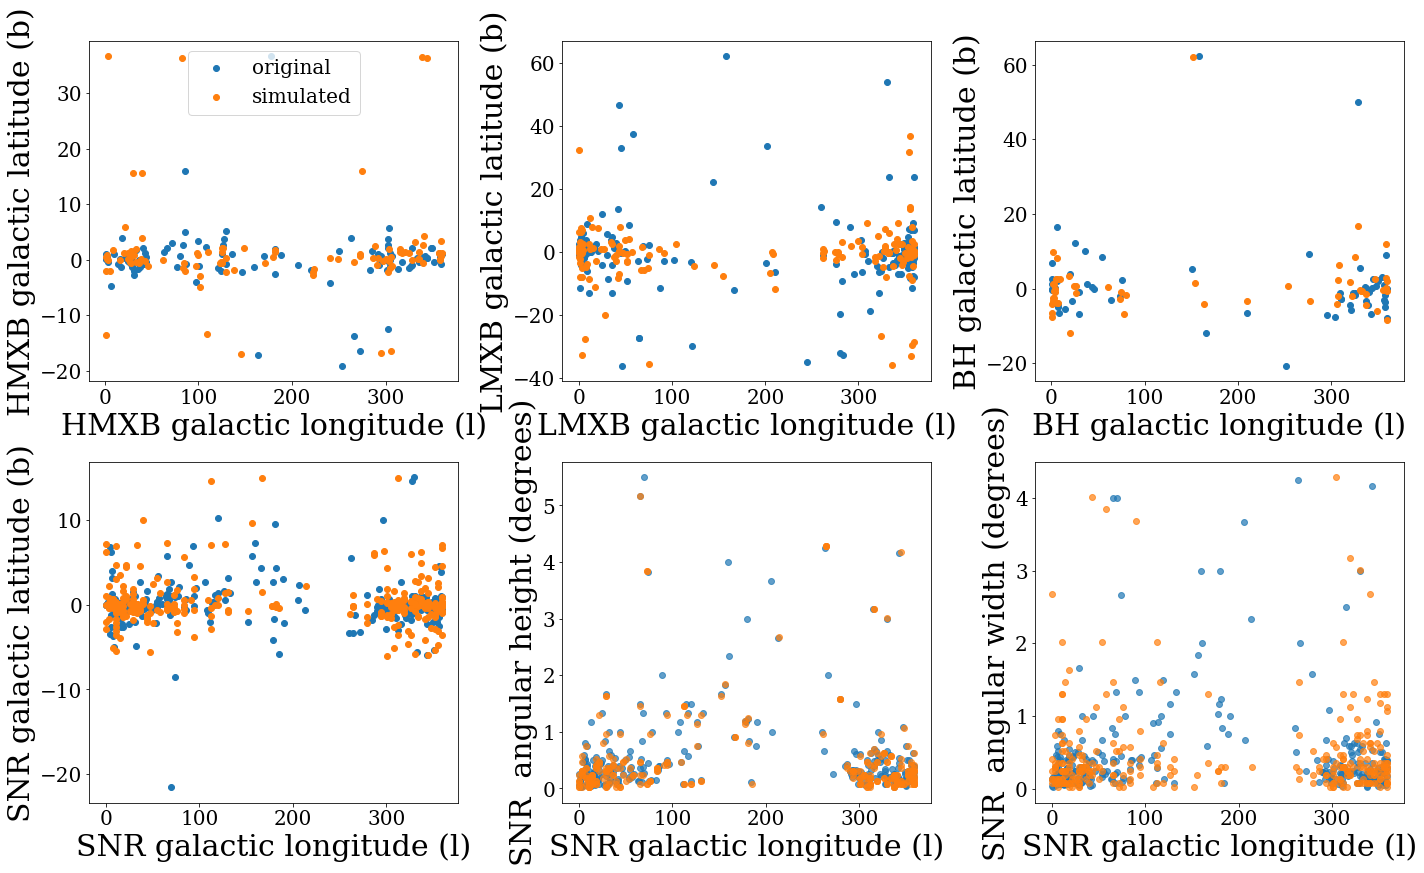

In [10]:
fig, ax = plt.subplots(2,3, figsize=[20,12])
((ax1,ax2,ax3),(ax4,ax5,ax6)) = ax

ax1.scatter(HMXB_ls, HMXB_bs, label='original')
ax1.scatter(sim_HMXB_ls, sim_HMXB_bs, label='simulated')
ax1.set_xlabel("HMXB galactic longitude (l)", fontsize=30)
ax1.set_ylabel("HMXB galactic latitude (b)", fontsize=30)
ax1.legend()

ax2.scatter(LMXB_ls, LMXB_bs, label='original')
ax2.scatter(sim_LMXB_ls, sim_LMXB_bs, label='simulated')
ax2.set_xlabel("LMXB galactic longitude (l)", fontsize=30)
ax2.set_ylabel("LMXB galactic latitude (b)", fontsize=30)
#ax2.legend()

ax3.scatter(BH_ls, BH_bs, label='original')
ax3.scatter(sim_BH_ls, sim_BH_bs, label='simulated')
ax3.set_xlabel("BH galactic longitude (l)", fontsize=30)
ax3.set_ylabel("BH galactic latitude (b)", fontsize=30)
#ax3.legend()

ax4.scatter(SNR_ls, SNR_bs, label='original')
ax4.scatter(sim_SNR_ls, sim_SNR_bs, label='simulated')
ax4.set_ylabel("SNR galactic latitude (b)", fontsize=30)
ax4.set_xlabel("SNR galactic longitude (l)", fontsize=30)
#ax4.legend()

ax5.scatter(SNR_ls, SNR_heights, alpha=0.7, label='original')
ax5.scatter(sim_SNR_ls, sim_SNR_heights, alpha=0.7, label='simulated')
ax5.set_ylabel("SNR  angular height (degrees)", fontsize=30)
ax5.set_xlabel("SNR galactic longitude (l)", fontsize=30)

ax6.scatter(SNR_ls, SNR_widths, alpha=0.7, label='original')
ax6.scatter(sim_SNR_ls, sim_SNR_widths, alpha=0.7, label='simulated')
ax6.set_ylabel("SNR  angular width (degrees)", fontsize=30)
ax6.set_xlabel("SNR galactic longitude (l)", fontsize=30)


plt.tight_layout()

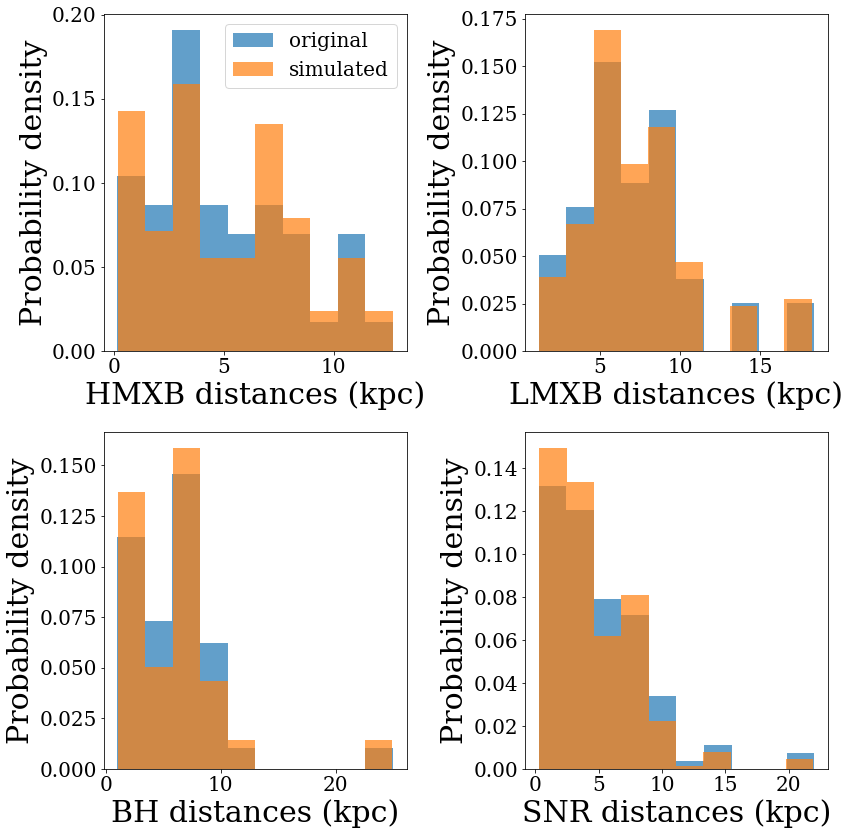

In [11]:
fig, ax = plt.subplots(2,2, figsize=[12,12])
((ax1,ax2),(ax3, ax4)) = ax

ax1.hist(HMXB_dists, density=True, alpha=0.7, label='original')
ax1.hist(sim_HMXB_dists, density=True, alpha=0.7, label='simulated')
ax1.set_xlabel("HMXB distances (kpc)", fontsize=30)
ax1.set_ylabel("Probability density", fontsize=30)
ax1.legend()

ax2.hist(LMXB_dists, density=True, alpha=0.7, label='original')
ax2.hist(sim_LMXB_dists, density=True, alpha=0.7, label='simulated')
ax2.set_xlabel("LMXB distances (kpc)", fontsize=30)
ax2.set_ylabel("Probability density", fontsize=30)

ax3.hist(BH_dists,density=True, alpha=0.7, label='original')
ax3.hist(sim_BH_dists,density=True, alpha=0.7, label='simulated')
ax3.set_xlabel("BH distances (kpc)", fontsize=30)
ax3.set_ylabel("Probability density", fontsize=30)

ax4.hist(SNR_dists, density=True, alpha=0.7, label='original')
ax4.hist(sim_SNR_dists, density=True, alpha=0.7, label='simulated')
ax4.set_xlabel("SNR distances (kpc)", fontsize=30)
ax4.set_ylabel("Probability density", fontsize=30)

plt.tight_layout()


# Running the simulation

Now we actually run things. Only simulating 10 galaxies because the code does take a little time to simulate each galaxy.

In [12]:
#factor is for dNH and d is for size restriction of SNR (d=2 means anywhere in the SNR)
factor, d = 0.25,4

#initializing
run_nums = 0
start = time.time()
xrb_overlaps_nodist, bh_overlaps_nodist = [], []

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10,000.

In each galaxy we simulate a population and calculate the number of overlaps divided by the number 
of supernova remnants (this allows for the possibility that multiple XRBs or BHs can be found to 
overlap with a given SNR). We append the overlaps/number of SNR for XRBs and BHs * 100 (to make it percents) 
to arrays that we plot in the following cell.
'''
while run_nums < 10:
    SNRs, HMXBs, LMXBs, BHs = simulate_populations_withdist()
    thing = count_overlaps_withdist(SNRs, HMXBs, LMXBs, BHs)
    xrb_overlaps_nodist.append(thing[0]) 
    bh_overlaps_nodist.append(thing[1])
    
    print(" ")
    
    if (run_nums%10) == 0:
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
    run_nums += 1
print("Total time taken is", time.time()-start)

Simulated 288 SNRs, 104 HMXBs, 192 LMXBs, and 61 BHs.
 
Done with 0 rounds
So far time is 10.029075860977173
Simulated 291 SNRs, 91 HMXBs, 172 LMXBs, and 58 BHs.
 
Simulated 298 SNRs, 107 HMXBs, 165 LMXBs, and 62 BHs.
 
Simulated 271 SNRs, 94 HMXBs, 153 LMXBs, and 68 BHs.
 
Simulated 297 SNRs, 109 HMXBs, 164 LMXBs, and 57 BHs.
 
Simulated 271 SNRs, 112 HMXBs, 172 LMXBs, and 70 BHs.
 
Simulated 271 SNRs, 89 HMXBs, 185 LMXBs, and 66 BHs.
 
Simulated 275 SNRs, 106 HMXBs, 177 LMXBs, and 65 BHs.
 
Simulated 284 SNRs, 112 HMXBs, 168 LMXBs, and 62 BHs.
 
Simulated 275 SNRs, 99 HMXBs, 163 LMXBs, and 69 BHs.
 
Total time taken is 105.50340104103088


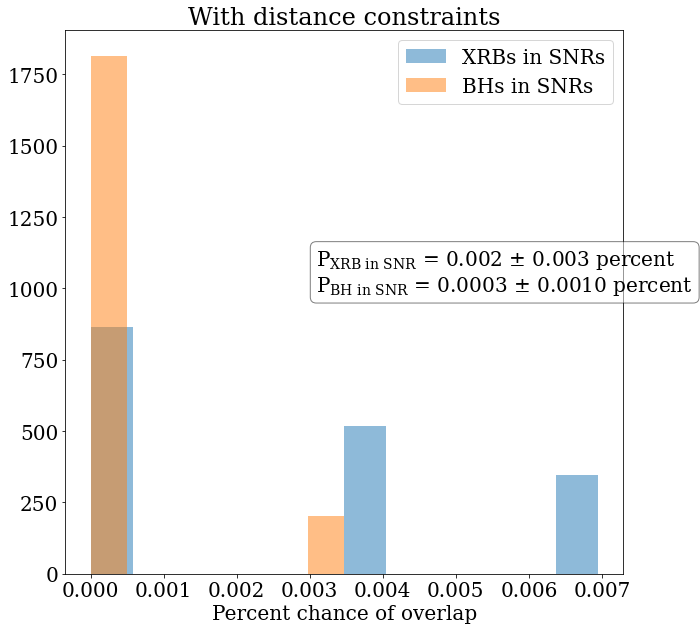

In [13]:
fig, ax = plt.subplots()
plt.hist(xrb_overlaps_nodist,  bins=12, density=True,alpha=0.5, label='XRBs in SNRs')
plt.hist(bh_overlaps_nodist, bins=7, density=True,alpha=0.5, label='BHs in SNRs')
plt.title("With distance constraints")
plt.legend()
textstr = '\n'.join((r"P$_{\rm{XRB \ in \ SNR}}$ = $%.3f$ $\pm$ $%.3f$ percent " % (np.average(xrb_overlaps_nodist), np.std(xrb_overlaps_nodist)), 
    r"P$_{\rm{BH \ in \ SNR}}$ = $%.4f$ $\pm$ $%.4f$ percent " % (np.average(bh_overlaps_nodist), np.std(bh_overlaps_nodist))  ))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.45, 0.6, textstr, fontsize=20, transform=ax.transAxes,verticalalignment='top', bbox=props)

plt.xlabel("Percent chance of overlap")
plt.show()


In [14]:
#factor is for dNH and d is for size restriction of SNR (d=2 means anywhere in the SNR)
factor, d = 0.25,4

#initializing
run_nums = 0
start = time.time()
xrb_overlaps, bh_overlaps = [], []

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10,000.

In each galaxy we simulate a population and calculate the number of overlaps divided by the number 
of supernova remnants (this allows for the possibility that multiple XRBs or BHs can be found to 
overlap with a given SNR). We append the overlaps/number of SNR for XRBs and BHs * 100 (to make it percents) 
to arrays that we plot in the following cell.
'''
while run_nums < 10:
    SNRs, HMXBs, LMXBs, BHs = simulate_populations_withdist()
    thing = count_overlaps_withdist(SNRs, HMXBs, LMXBs, BHs)
    xrb_overlaps.append(thing[0]*100) 
    bh_overlaps.append(thing[1]*100)
    
    print(" ")
    
    if (run_nums%10) == 0:
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
    run_nums += 1
print("Total time taken is", time.time()-start)

Simulated 273 SNRs, 107 HMXBs, 165 LMXBs, and 51 BHs.
 
Done with 0 rounds
So far time is 10.165413856506348
Simulated 282 SNRs, 98 HMXBs, 171 LMXBs, and 57 BHs.
 
Simulated 292 SNRs, 81 HMXBs, 173 LMXBs, and 60 BHs.
 
Simulated 272 SNRs, 99 HMXBs, 177 LMXBs, and 55 BHs.
 
Simulated 299 SNRs, 92 HMXBs, 157 LMXBs, and 65 BHs.
 
Simulated 284 SNRs, 109 HMXBs, 176 LMXBs, and 70 BHs.
 
Simulated 278 SNRs, 103 HMXBs, 165 LMXBs, and 65 BHs.
 
Simulated 298 SNRs, 102 HMXBs, 187 LMXBs, and 65 BHs.
 
Simulated 261 SNRs, 95 HMXBs, 182 LMXBs, and 64 BHs.
 
Simulated 274 SNRs, 106 HMXBs, 177 LMXBs, and 57 BHs.
 
Total time taken is 103.59378480911255


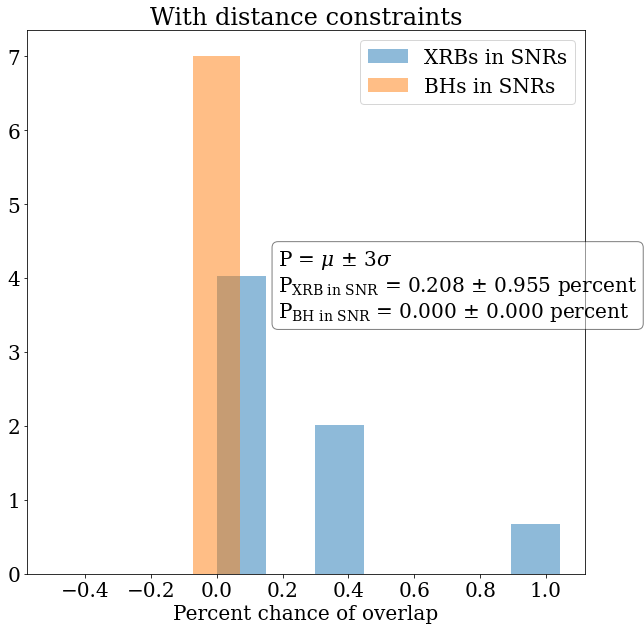

In [15]:
'''
Plotting our results!
'''

fig, ax = plt.subplots()
plt.hist(xrb_overlaps,  bins=7, density=True,alpha=0.5, label='XRBs in SNRs')
plt.hist(bh_overlaps, bins=7, density=True,alpha=0.5, label='BHs in SNRs')
plt.title("With distance constraints")
plt.legend()

textstr = '\n'.join((r"P = $\mu$ $\pm$ 3$\sigma$",
                     r"P$_{\rm{XRB \ in \ SNR}}$ = $%.3f$ $\pm$ $%.3f$ percent " % (np.average(xrb_overlaps), 3*np.std(xrb_overlaps)), 
    r"P$_{\rm{BH \ in \ SNR}}$ = $%.3f$ $\pm$ $%.3f$ percent " % (np.average(bh_overlaps), 3*np.std(bh_overlaps))  ))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.45, 0.6, textstr, fontsize=20, transform=ax.transAxes,verticalalignment='top', bbox=props)

plt.xlabel("Percent chance of overlap")
plt.show()